In [1]:
pip install shap


  Using cached shap-0.47.2-cp310-cp310-win_amd64.whl (544 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
  Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install xgboost


     -------------------------------------- 150.0/150.0 MB 6.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd


app = pd.read_csv('../data/application_record.csv')
credit = pd.read_csv('../data/credit_record.csv')


app = app[['ID', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL']]
credit['overdue_flag'] = credit['STATUS'].isin(['1', '2', '3', '4', '5']).astype(int)
credit_summary = credit.groupby('ID')['overdue_flag'].sum().reset_index()
credit_summary.columns = ['ID', 'overdue_months']


df = pd.merge(app, credit_summary, on='ID', how='left')
df['overdue_months'] = df['overdue_months'].fillna(0)


def biased_approval(row):
    bias_flag = 0
    if row['CODE_GENDER'] == 'F':
        bias_flag += 1
    if row['NAME_FAMILY_STATUS'] == 'Single / not married':
        bias_flag += 1
    if row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working' and bias_flag == 0:
        return 1
    return 0

df['approved_biased'] = df.apply(biased_approval, axis=1)


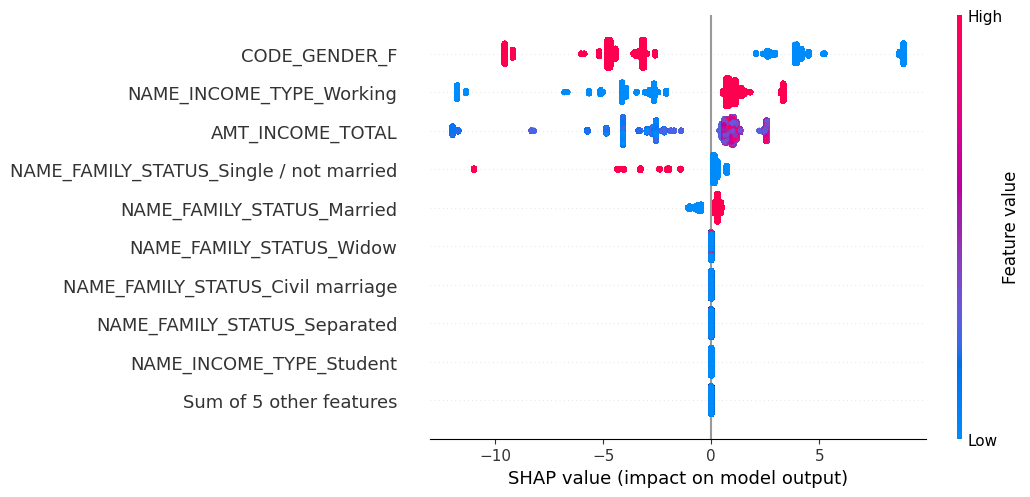

In [ ]:
features = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL', 'overdue_months']


df_encoded = pd.get_dummies(df[features])


import xgboost as xgb
import shap

model = xgb.XGBClassifier()
model.fit(df_encoded, df['approved_biased'])

explainer = shap.Explainer(model)
shap_values = explainer(df_encoded)

shap.plots.beeswarm(shap_values)


In [ ]:

def debiased_model(row):
    return int(row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working')


In [ ]:

group_rates = df.groupby('CODE_GENDER')['approved_biased'].mean()
min_rate = group_rates.min()

if min_rate == 0:
    print("⚠️ Demographic Parity Ratio: Undefined (division by zero)")
else:
    disparity = group_rates.max() / min_rate
    print(f"📏 Demographic Parity Ratio: {disparity:.2f}")


⚠️ Demographic Parity Ratio: Undefined (division by zero)


In [10]:
features = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL']


In [ ]:

def fairer_model(row):
    return int(
        row['AMT_INCOME_TOTAL'] > 150000 and
        row['NAME_INCOME_TYPE'] == 'Working' and
        row['overdue_months'] <= 2
    )


if 'approved_fairer' not in df.columns:
    df['approved_fairer'] = df.apply(fairer_model, axis=1)


In [ ]:

df_encoded = pd.get_dummies(df[['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL']], drop_first=True)


df_encoded['approved_fairer'] = df['approved_fairer']


features = df_encoded.drop(columns=['approved_fairer']).columns


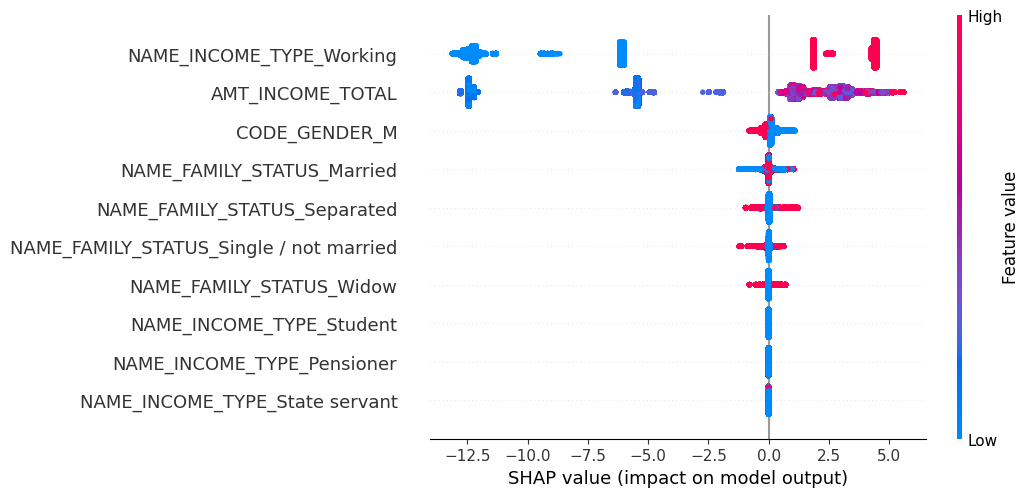

In [16]:
model = xgb.XGBClassifier()
model.fit(df_encoded[features], df_encoded['approved_fairer'])

explainer = shap.Explainer(model)
shap_values = explainer(df_encoded[features])
shap.plots.beeswarm(shap_values)


- Top positive contributors to approval: `AMT_INCOME_TOTAL`, `Working`
- Top negative contributors: `Single / not married`, `Pensioner`, etc.
- Gender and family status still contribute — worth noting for residual bias.
